In [1]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import operator 
import json
from collections import Counter
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
import datetime as dt
pd.set_option('display.max_colwidth', -1)


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# (1) Loading data + parse time -> date | dayOfWeek | timeOnPage | hostName | extracting some key words to a column (ping, sql...)

In [4]:
def dateparse (time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

def get_regex_from_string(string, url_regex):
    urls = re.compile(url_regex, re.VERBOSE | re.IGNORECASE)
    return urls.findall(string)

def is_list_bigger_than_zero(list):
    if len(list)>0:
        return 1
    else:
        return 0
    

In [6]:
df = pd.read_csv('/Users/alex/Downloads/alerts.csv',
                 sep=',', 
                 lineterminator='\n', 
                 parse_dates=True,
                 date_parser=dateparse,
                 encoding = 'utf8',)

df['time'] = pd.to_datetime(df.time, unit='s')
df['date'] = df['time'].dt.date
df['hour'] = df['time'].dt.hour
df['dayOfWeek'] = df['time'].dt.strftime('%A')
df['timeOnDay']=df['time'].dt.time
df['isEndingWith_com'] = df.apply(lambda row: is_list_bigger_than_zero(get_regex_from_string(row['host'], r'.com')),axis=1)
df['host_no_numbers'] = df.apply(lambda row: ''.join([i for i in row['host'] if not i.isdigit()]), axis=1)
df['ping_related'] = df['type'].str.lower().str.contains("ping").astype(int)
df['load_related'] = df['type'].str.lower().str.contains("load").astype(int)
df['sql_related'] = df['type'].str.lower().str.contains("sql").astype(int)
df['memcach_related'] = df['type'].str.lower().str.contains("memcach").astype(int)
df['storage_related'] = df['type'].str.lower().str.contains("storage").astype(int)
df['cpu_related'] = df['type'].str.lower().str.contains("cpu").astype(int)
df['host_type_combined'] = df['host_no_numbers'] +'_' + df['type']
dataSize = df.shape
print("Data loaded: {}".format(dataSize))


Data loaded: (156884, 16)


In [5]:
df.head()

,time,host,type,date,hour,dayOfWeek,timeOnDay,isEndingWith_com,host_no_numbers,ping_related,load_related,sql_related,memcach_related,storage_related,cpu_related,host_type_combined
0,2016-05-18 12:00:04,pmas02.vs1.acme.com,check_timeOffset,2016-05-18,12,Wednesday,12:00:04,1,pmas.vs.acme.com,0,0,0,0,0,0,pmas.vs.acme.com_check_timeOffset
1,2016-05-18 22:06:11,signer01.corp.acme.com,no_ping_to_host,2016-05-18,22,Wednesday,22:06:11,1,signer.corp.acme.com,1,0,0,0,0,0,signer.corp.acme.com_no_ping_to_host
2,2016-05-18 22:10:01,signer02.corp.acme.com,no_ping_to_host,2016-05-18,22,Wednesday,22:10:01,1,signer.corp.acme.com,1,0,0,0,0,0,signer.corp.acme.com_no_ping_to_host
3,2016-05-20 10:13:33,armbutlhme1.acme.com,gdma_l_snmp_TimeOffset,2016-05-20,10,Friday,10:13:33,1,armbutlhme.acme.com,0,0,0,0,0,0,armbutlhme.acme.com_gdma_l_snmp_TimeOffset
4,2016-05-20 10:13:53,armbutlhme1.acme.com,gdma_l_snmp_alive,2016-05-20,10,Friday,10:13:53,1,armbutlhme.acme.com,0,0,0,0,0,0,armbutlhme.acme.com_gdma_l_snmp_alive


In [7]:
df = df.sort_values(['time'],ascending=True)

# (2) Get to know the data a bit

In [8]:
pd.isnull(df).sum()

time                  0
host                  0
type                  0
date                  0
hour                  0
dayOfWeek             0
timeOnDay             0
isEndingWith_com      0
host_no_numbers       0
ping_related          0
load_related          0
sql_related           0
memcach_related       0
storage_related       0
cpu_related           0
host_type_combined    0
dtype: int64

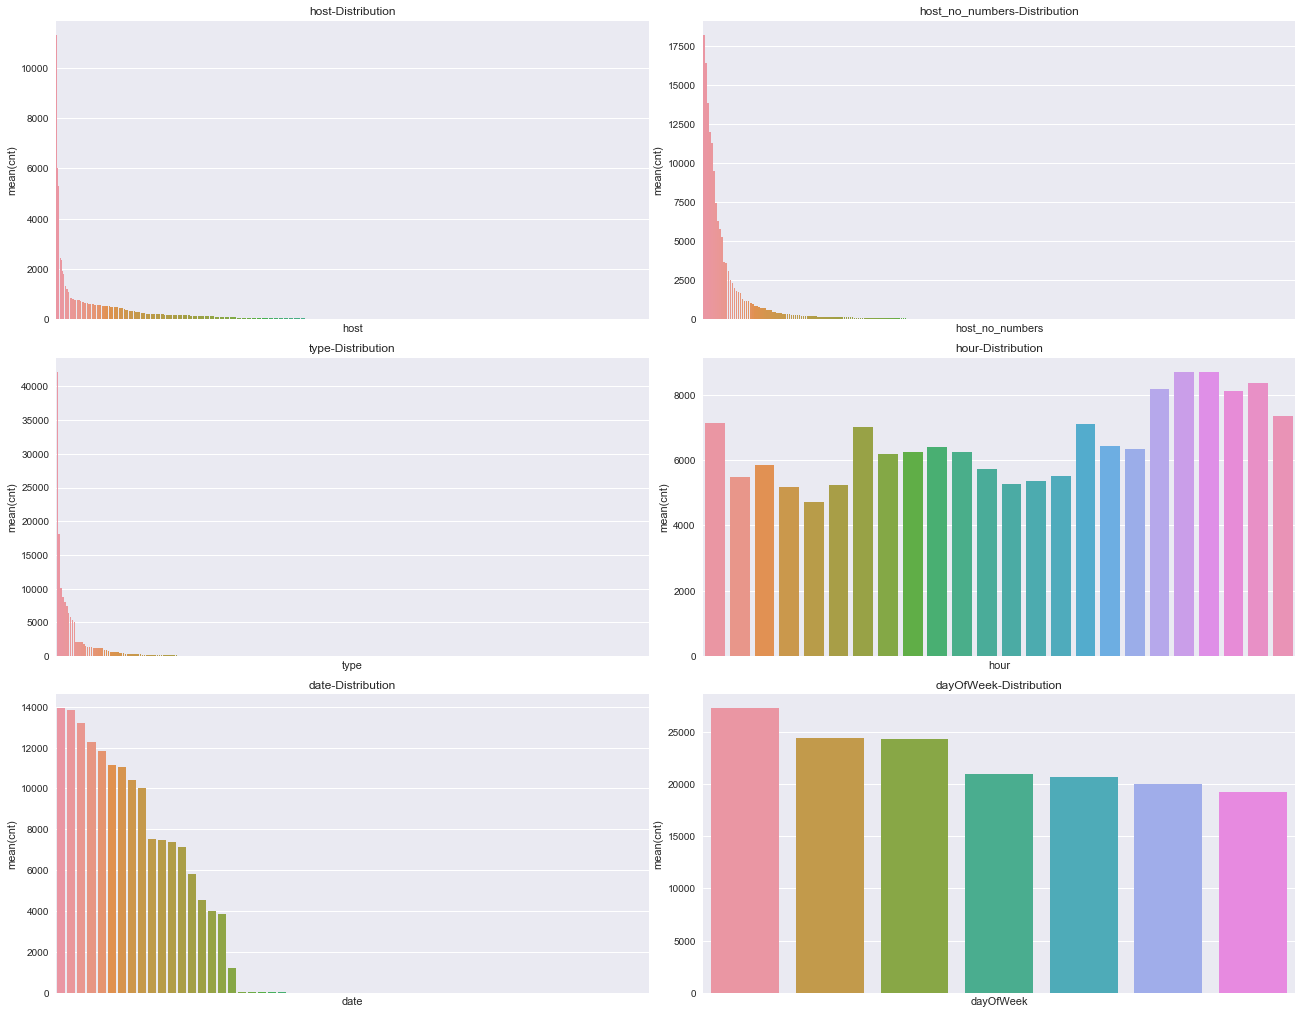

In [9]:
categorical = ['host','host_no_numbers','type','hour','date','dayOfWeek']
i=1
plt.figure(figsize=(18,14))
for dim in categorical:
    df_grouped = df.groupby([dim]).agg({'time':'count'})\
    .reset_index().rename(columns={'time': 'cnt'}).sort_values(['cnt'],ascending=False)
    plt.subplot(3,2,i)
    sns.barplot(df_grouped[dim],df_grouped['cnt'])
    plt.title('{}-Distribution'.format(dim))
    plt.xticks([])
    i=i+1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

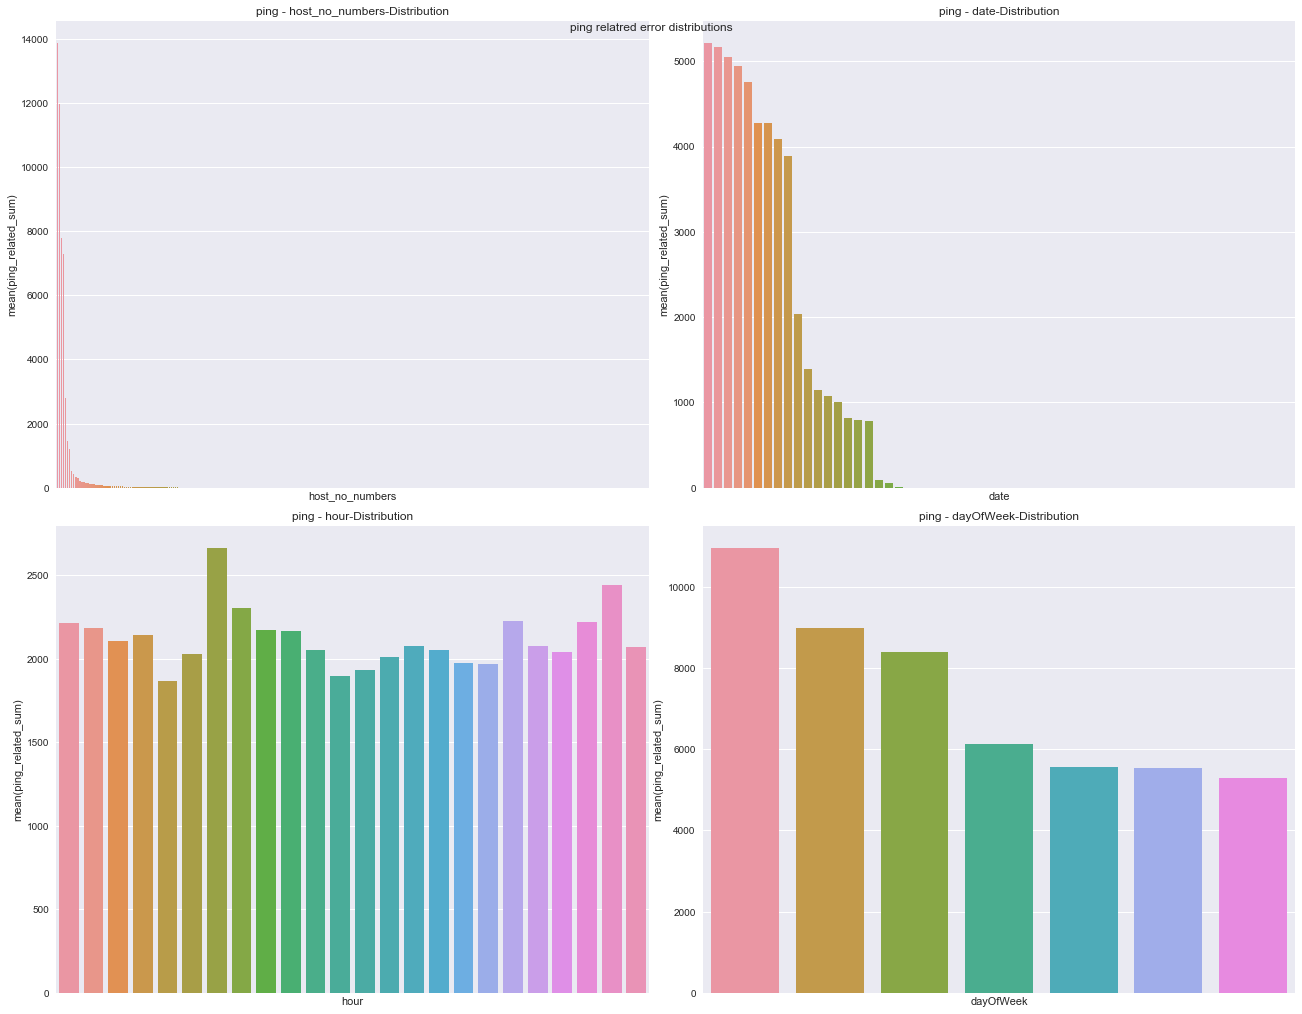

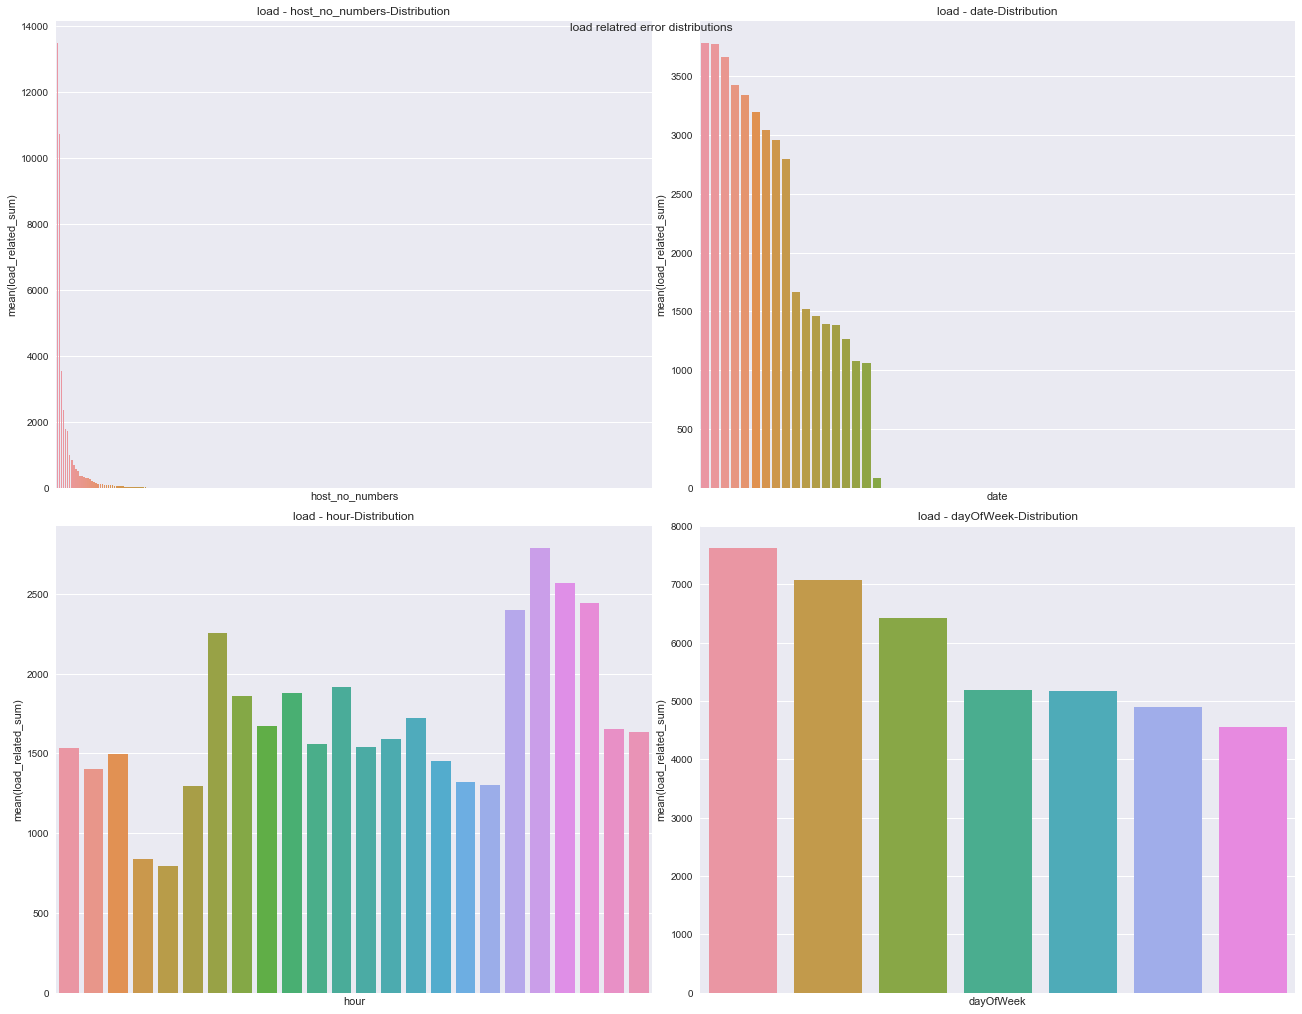

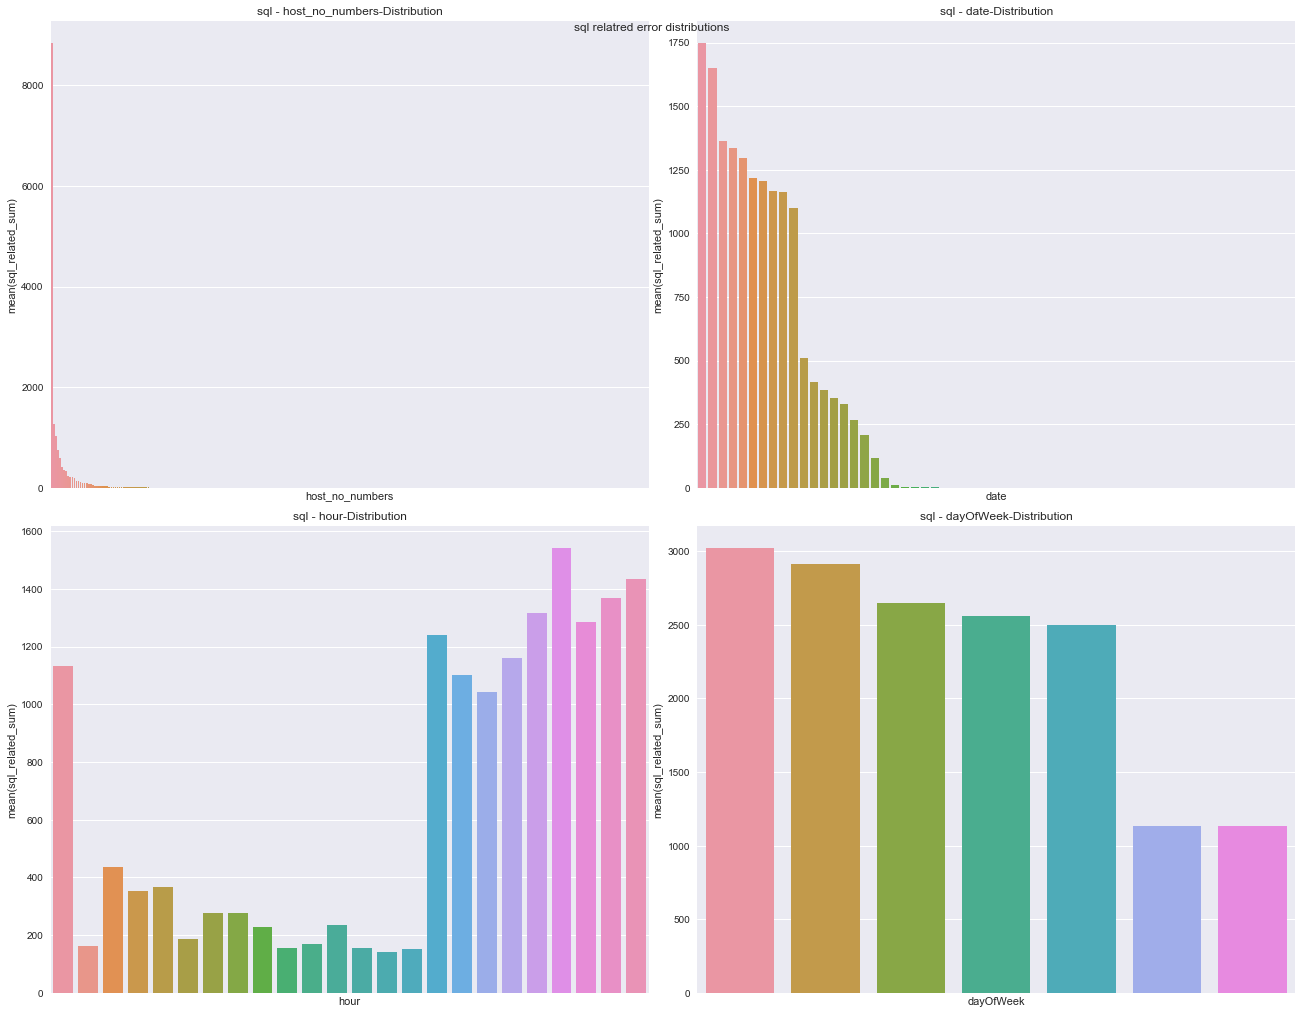

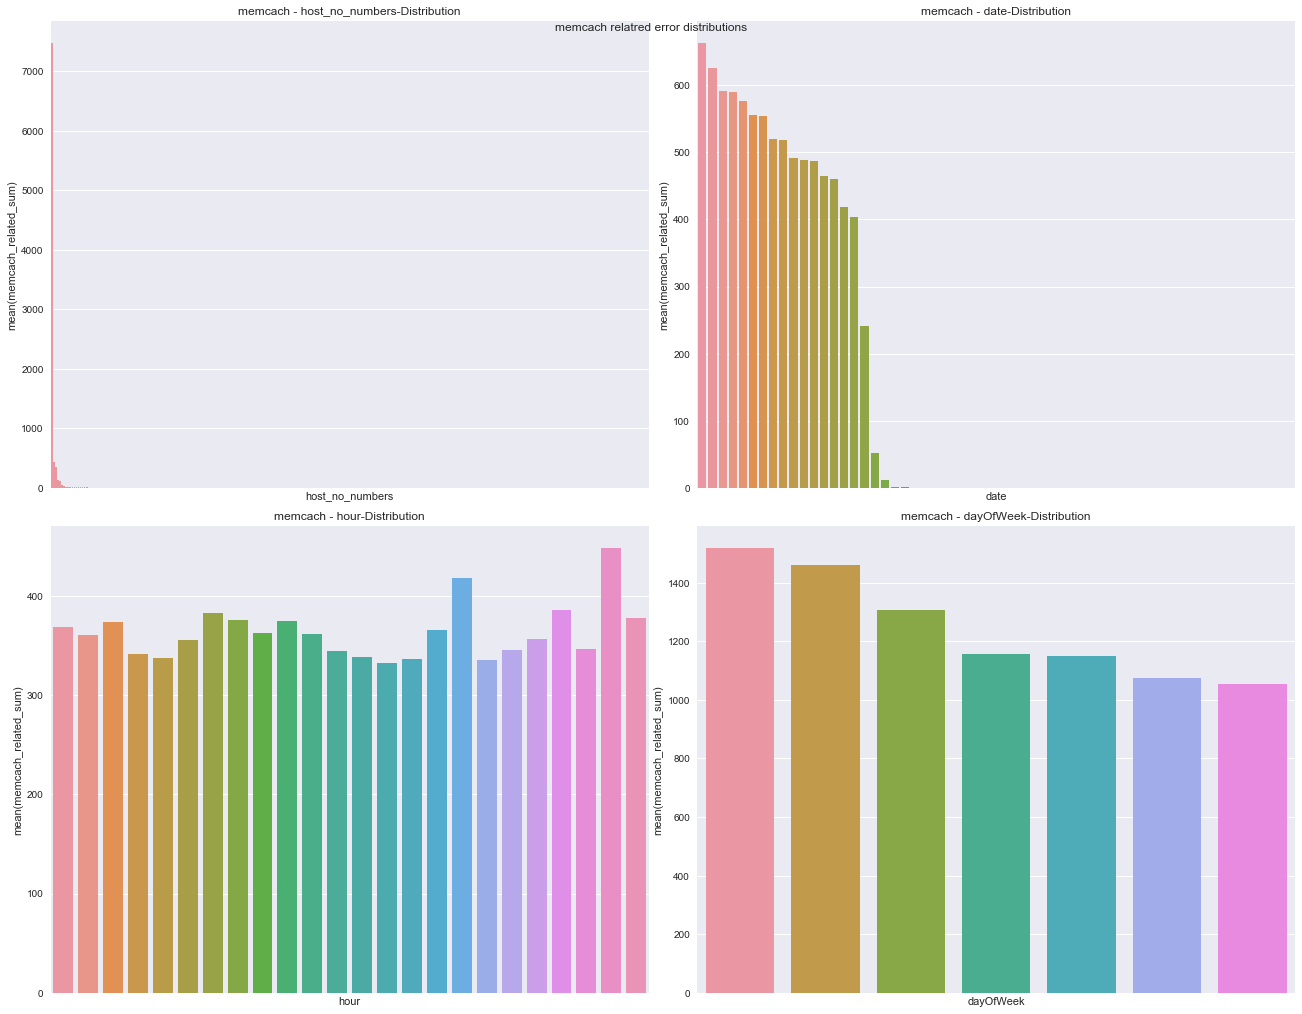

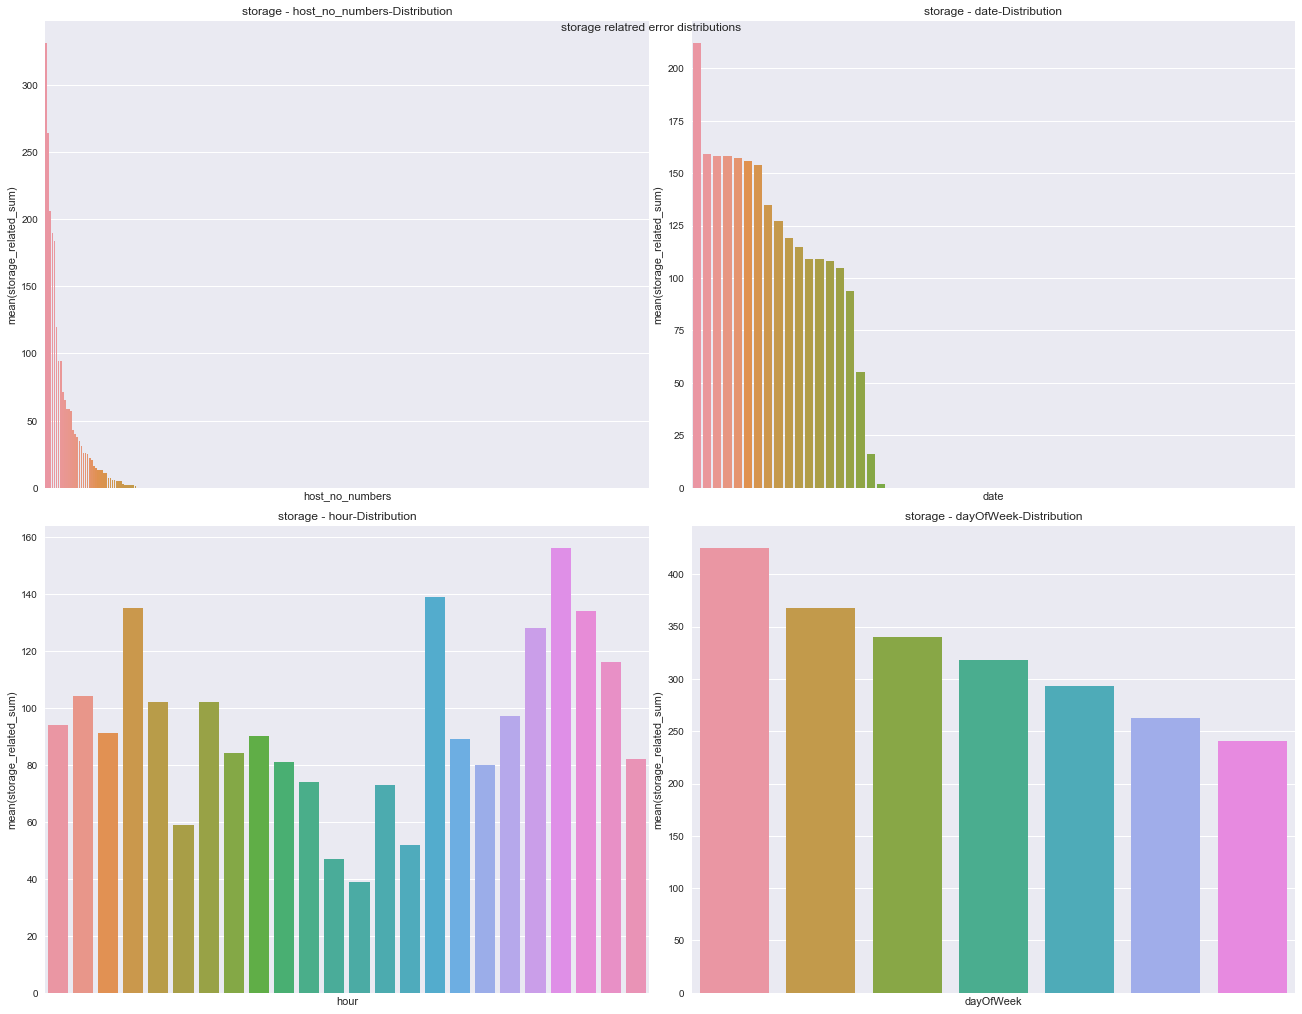

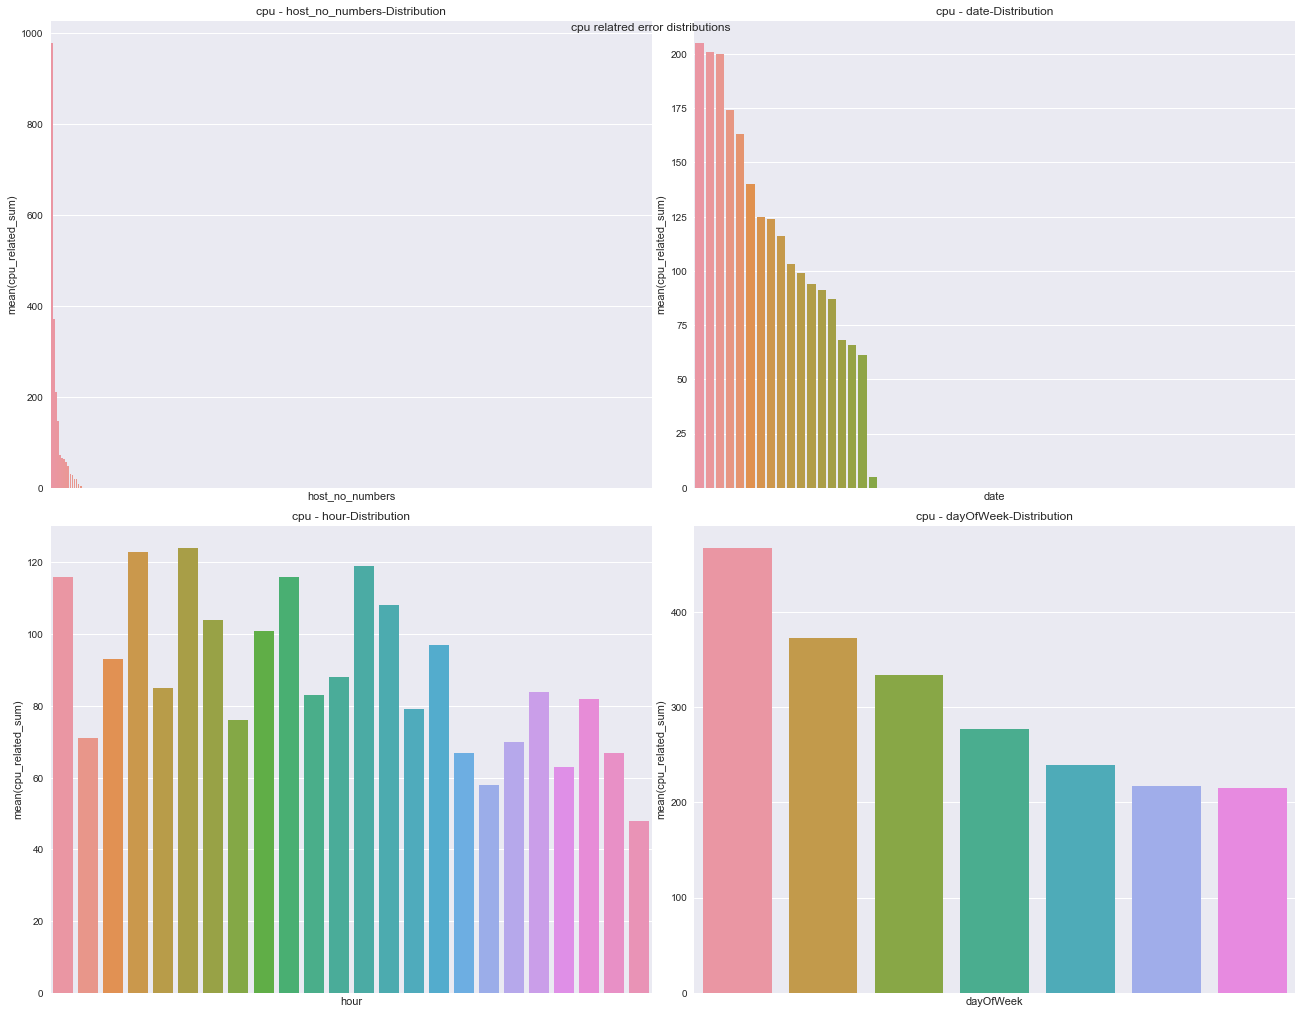

In [10]:
errorType = ['ping','load','sql','memcach','storage','cpu']
for error in errorType:     
    categorical = ['host_no_numbers','date','hour','dayOfWeek']
    i=1
    plt.figure(figsize=(18,14))
    for dim in categorical:
        df_grouped = df.groupby([dim]).agg({error+'_related':'sum'})\
        .reset_index().rename(columns={error+'_related': error+'_related_sum'}).sort_values([error+'_related_sum'],ascending=False)
        plt.subplot(2,2,i)
        sns.barplot(df_grouped[dim],df_grouped[error+'_related_sum'])
        plt.title('{} - {}-Distribution'.format(error,dim))
        plt.xticks([])
        i=i+1
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    
    plt.suptitle('{} relatred error distributions'.format(error))


# (3) Group By 'date','hour','host_no_numbers','type','host_type_combined' -> check if we have some N-grams that are frequent

In [11]:
df_grouped = df.groupby(['date','hour','host_no_numbers','type','host_type_combined']).agg({'time':'min'})\
        .reset_index().sort_values(['date','hour','time'],ascending=True)

    

In [12]:
df_grouped.head()

,date,hour,host_no_numbers,type,host_type_combined,time
0,2016-05-18,12,pmas.vs.acme.com,check_timeOffset,pmas.vs.acme.com_check_timeOffset,2016-05-18 12:00:04
1,2016-05-18,22,signer.corp.acme.com,no_ping_to_host,signer.corp.acme.com_no_ping_to_host,2016-05-18 22:06:11
2,2016-05-20,10,armbutlhme.acme.com,gdma_l_snmp_TimeOffset,armbutlhme.acme.com_gdma_l_snmp_TimeOffset,2016-05-20 10:13:33
3,2016-05-20,10,armbutlhme.acme.com,gdma_l_snmp_alive,armbutlhme.acme.com_gdma_l_snmp_alive,2016-05-20 10:13:53
6,2016-05-20,10,armbutlhme.acme.com,gdma_l_snmp_storage,armbutlhme.acme.com_gdma_l_snmp_storage,2016-05-20 10:14:28


In [13]:
from nltk.util import ngrams
from nltk import FreqDist
terms_type = [term for term in df_grouped['type']]
terms_host = [term for term in df_grouped['host_no_numbers']]
terms_host_type = [term for term in df_grouped['host_type_combined']]

n_grams_combined=ngrams(terms_host_type,6)

fdist= FreqDist(n_grams_combined)

In [14]:
fdist.most_common(10)

[(('appdbqa.acme.com_url_generic_Emt_Stale_Data',
   'appdbqa.acme.com_url_generic_MySQL_Commit_Check',
   'appdbqa.acme.com_url_generic_MySQL_Error_Log_Growth',
   'appdbqa.acme.com_url_generic_MySQL_Read_Only',
   'appdbqa.acme.com_url_generic_MySQL_Stuck_Temporary_Table',
   'armbutlhme.acme.com_no_ping_to_host'),
  8),
 (('appdbqa.acme.com_url_generic_Emt_Stale_Data',
   'appdbqa.acme.com_url_generic_Monitor_Configuration',
   'appdbqa.acme.com_url_generic_MySQL_Commit_Check',
   'appdbqa.acme.com_url_generic_MySQL_Error_Log_Growth',
   'appdbqa.acme.com_url_generic_MySQL_Read_Only',
   'appdbqa.acme.com_url_generic_MySQL_Stuck_Temporary_Table'),
  6),
 (('as.tp.acme.com_service-tp1-prod-snmp-uptime',
   'appdbqa.acme.com_url_generic_Emt_Stale_Data',
   'appdbqa.acme.com_url_generic_MySQL_Commit_Check',
   'appdbqa.acme.com_url_generic_MySQL_Error_Log_Growth',
   'appdbqa.acme.com_url_generic_MySQL_Read_Only',
   'appdbqa.acme.com_url_generic_MySQL_Stuck_Temporary_Table'),
  6),
 (

# (4) Bucket host names, alerts and a combination of the 2 using Affinity-Propagation clustering model.

In [15]:
import numpy as np
import sklearn.cluster
import distance

words = [term for term in df_grouped['host_type_combined'].unique()] 
words = np.asarray(words) 
lev_similarity = -1*np.array([[distance.levenshtein(w1,w2) for w1 in words] for w2 in words])



In [16]:
hosts = [term for term in df_grouped['host_no_numbers'].unique()]
hosts = np.asarray(hosts) 
hosts_lev_similarity = -1*np.array([[distance.levenshtein(w1,w2) for w1 in hosts] for w2 in hosts])

In [17]:
alerts = [term for term in df_grouped['type'].unique()]
alerts = np.asarray(alerts) 
alerts_lev_similarity = -1*np.array([[distance.levenshtein(w1,w2) for w1 in alerts] for w2 in alerts])

In [18]:
hosts_affinity_propagation = sklearn.cluster.AffinityPropagation(affinity="precomputed", damping=0.7, max_iter=300)
hosts_affinity_propagation.fit(hosts_lev_similarity)

AffinityPropagation(affinity='precomputed', convergence_iter=15, copy=True,
          damping=0.7, max_iter=300, preference=None, verbose=False)

In [19]:
alets_affinity_propagation = sklearn.cluster.AffinityPropagation(affinity="precomputed", damping=0.7)
alets_affinity_propagation.fit(alerts_lev_similarity)

AffinityPropagation(affinity='precomputed', convergence_iter=15, copy=True,
          damping=0.7, max_iter=200, preference=None, verbose=False)

In [20]:
combined_affinity_propagation = sklearn.cluster.AffinityPropagation(affinity="precomputed", damping=0.7)
combined_affinity_propagation.fit(lev_similarity)

AffinityPropagation(affinity='precomputed', convergence_iter=15, copy=True,
          damping=0.7, max_iter=200, preference=None, verbose=False)

In [21]:
def get_cluster_id(affprop, string, word_sets):
    for clusterid in np.unique(affprop.labels_):
        cluster = np.unique(word_sets[np.nonzero(affprop.labels_== clusterid)])
        if string in cluster:
            return clusterid

In [22]:
df['host_cluster_id'] = df.apply(lambda row: get_cluster_id(hosts_affinity_propagation,row['host_no_numbers'],hosts) , axis=1)
df['alert_cluster_id'] = df.apply(lambda row: get_cluster_id(alets_affinity_propagation,row['type'],alerts) , axis=1)
df['host_alert_combinde_cluster_id'] = df.apply(lambda row: get_cluster_id(combined_affinity_propagation,row['host_type_combined'],words) , axis=1)

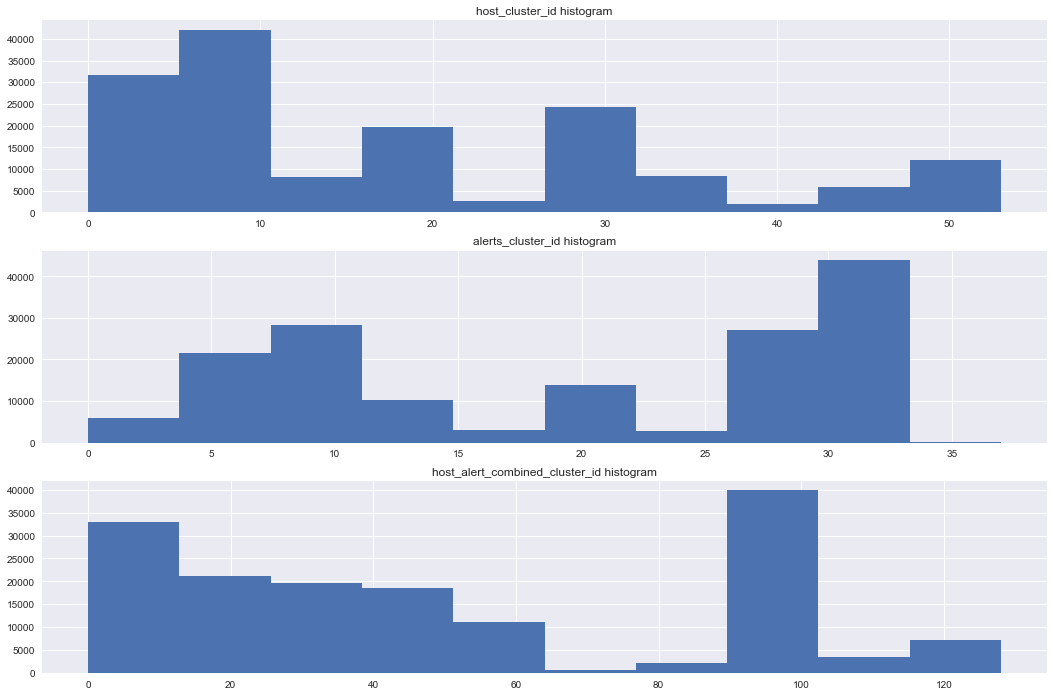

In [23]:
plt.figure(figsize=(18,12))
plt.subplot(3,1,1)
df['host_cluster_id'].hist()
plt.title('host_cluster_id histogram')
plt.subplot(3,1,2)
df['alert_cluster_id'].hist()
plt.title('alerts_cluster_id histogram')
plt.subplot(3,1,3)
df['host_alert_combinde_cluster_id'].hist()
plt.title('host_alert_combined_cluster_id histogram')

In [24]:
df['timestamp'] = df['time'].values.astype(np.int64)
df['hour_minute'] = df['hour']*100+df['time'].dt.minute
df['dayOfWeekInt'] = df['time'].dt.dayofweek

In [25]:
df.head()

,time,host,type,date,hour,dayOfWeek,timeOnDay,isEndingWith_com,host_no_numbers,ping_related,...,memcach_related,storage_related,cpu_related,host_type_combined,host_cluster_id,alert_cluster_id,host_alert_combinde_cluster_id,timestamp,hour_minute,dayOfWeekInt
0,2016-05-18 12:00:04,pmas02.vs1.acme.com,check_timeOffset,2016-05-18,12,Wednesday,12:00:04,1,pmas.vs.acme.com,0,...,0,0,0,pmas.vs.acme.com_check_timeOffset,43,8,58,1463572804000000000,1200,2
1,2016-05-18 22:06:11,signer01.corp.acme.com,no_ping_to_host,2016-05-18,22,Wednesday,22:06:11,1,signer.corp.acme.com,1,...,0,0,0,signer.corp.acme.com_no_ping_to_host,26,31,12,1463609171000000000,2206,2
2,2016-05-18 22:10:01,signer02.corp.acme.com,no_ping_to_host,2016-05-18,22,Wednesday,22:10:01,1,signer.corp.acme.com,1,...,0,0,0,signer.corp.acme.com_no_ping_to_host,26,31,12,1463609401000000000,2210,2
3,2016-05-20 10:13:33,armbutlhme1.acme.com,gdma_l_snmp_TimeOffset,2016-05-20,10,Friday,10:13:33,1,armbutlhme.acme.com,0,...,0,0,0,armbutlhme.acme.com_gdma_l_snmp_TimeOffset,49,0,0,1463739213000000000,1013,4
4,2016-05-20 10:13:53,armbutlhme1.acme.com,gdma_l_snmp_alive,2016-05-20,10,Friday,10:13:53,1,armbutlhme.acme.com,0,...,0,0,0,armbutlhme.acme.com_gdma_l_snmp_alive,49,0,0,1463739233000000000,1013,4


# (5) The combination of the 2 creates too many groups -> we will use host names buckets & alerts buckets for grouping with another unsupervised clustering method

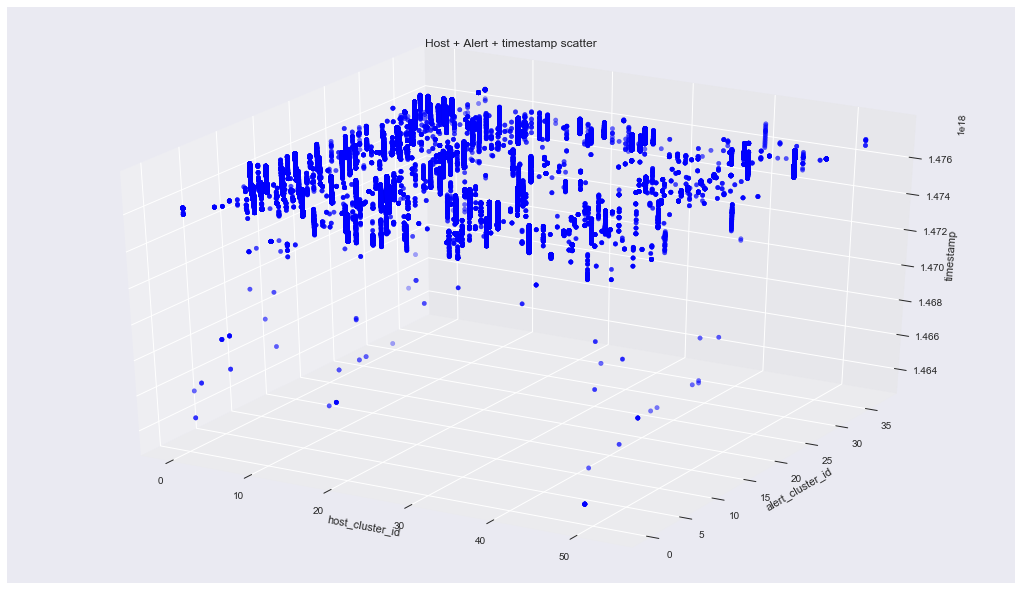

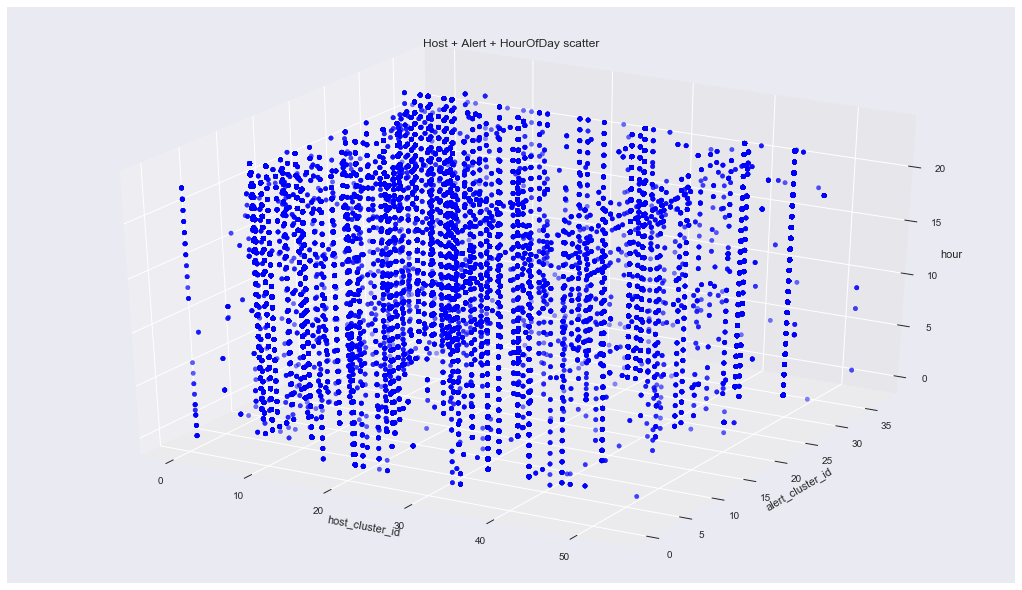

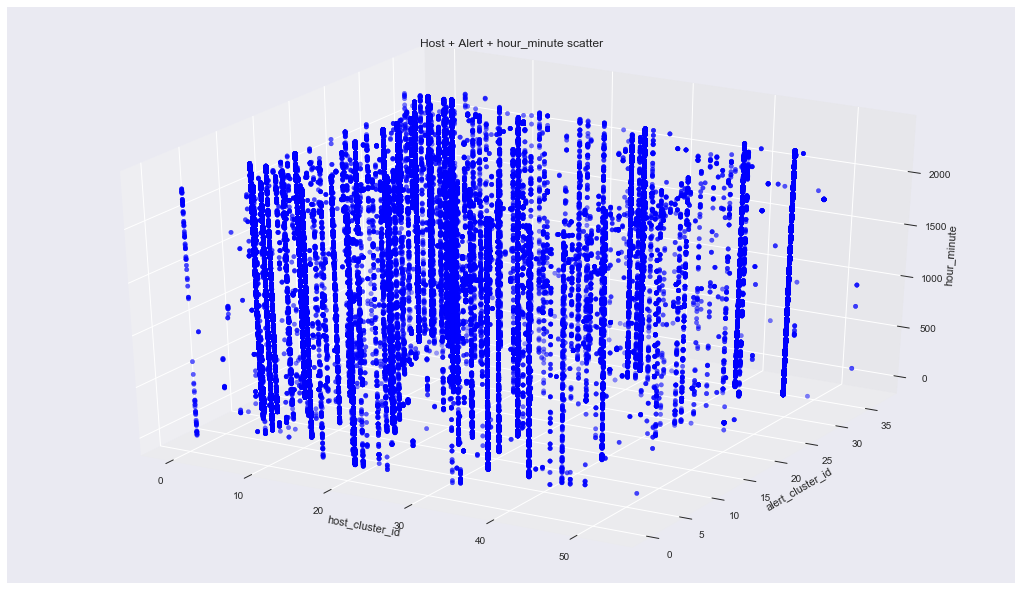

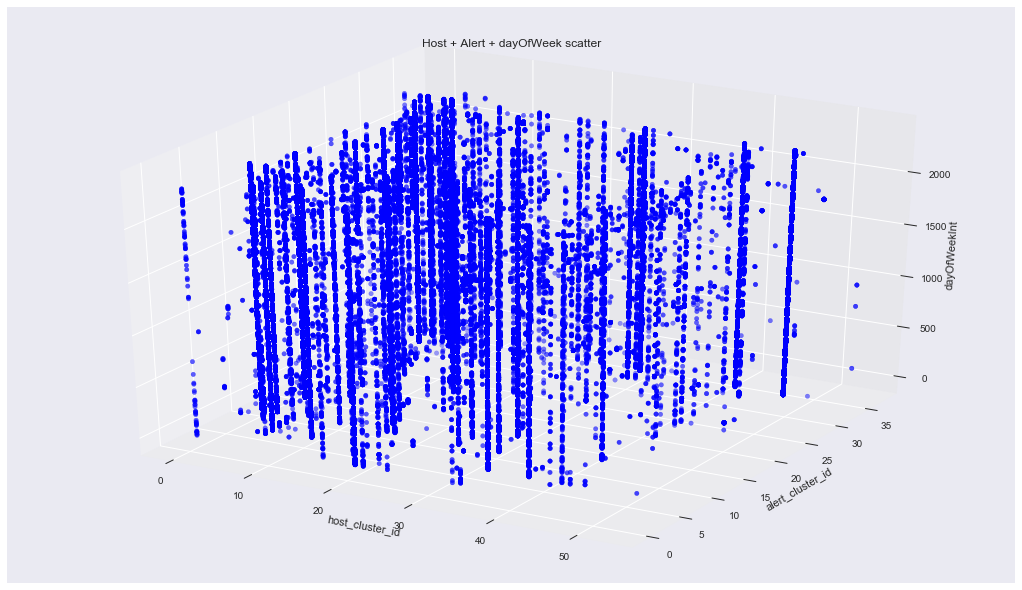

In [26]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14,8))
ax = Axes3D(fig)
ax.scatter(df['host_cluster_id'],df['alert_cluster_id'], df['timestamp'],c = 'b', marker='o')
ax.set_xlabel('host_cluster_id')
ax.set_ylabel('alert_cluster_id')
ax.set_zlabel('timestamp')
ax.set_title('Host + Alert + timestamp scatter')

fig = plt.figure(figsize=(14,8))
ax = Axes3D(fig)
ax.scatter(df['host_cluster_id'],df['alert_cluster_id'], df['hour'],c = 'b', marker='o')
ax.set_xlabel('host_cluster_id')
ax.set_ylabel('alert_cluster_id')
ax.set_zlabel('hour')
ax.set_title('Host + Alert + HourOfDay scatter')

fig = plt.figure(figsize=(14,8))
ax = Axes3D(fig)
ax.scatter(df['host_cluster_id'],df['alert_cluster_id'], df['hour_minute'],c = 'b', marker='o')
ax.set_xlabel('host_cluster_id')
ax.set_ylabel('alert_cluster_id')
ax.set_zlabel('hour_minute')
ax.set_title('Host + Alert + hour_minute scatter')

fig = plt.figure(figsize=(14,8))
ax = Axes3D(fig)
ax.scatter(df['host_cluster_id'],df['alert_cluster_id'], df['hour_minute'],c = 'b', marker='o')
ax.set_xlabel('host_cluster_id')
ax.set_ylabel('alert_cluster_id')
ax.set_zlabel('dayOfWeekInt')
ax.set_title('Host + Alert + dayOfWeek scatter')


# (6) It seems like time is not a good differentiator -> will use alertsBuckets + hostBuckets for grouping

In [27]:
df.to_csv('/Users/alex/Downloads/enriched_alerts', encoding='utf-8', index=False)


In [4]:
df = pd.read_csv('/Users/alex/Downloads/enriched_alerts.csv',
                 sep=',', 
                 lineterminator='\n', 
                 encoding = 'utf8')

In [5]:
df.head()

,time,host,type,date,hour,dayOfWeek,timeOnDay,isEndingWith_com,host_no_numbers,ping_related,...,memcach_related,storage_related,cpu_related,host_type_combined,host_cluster_id,alert_cluster_id,host_alert_combinde_cluster_id,timestamp,hour_minute,dayOfWeekInt
0,2016-05-18 12:00:04,pmas02.vs1.acme.com,check_timeOffset,2016-05-18,12,Wednesday,12:00:04,1,pmas.vs.acme.com,0,...,0,0,0,pmas.vs.acme.com_check_timeOffset,43,8,58,1463572804000000000,1200,2
1,2016-05-18 22:06:11,signer01.corp.acme.com,no_ping_to_host,2016-05-18,22,Wednesday,22:06:11,1,signer.corp.acme.com,1,...,0,0,0,signer.corp.acme.com_no_ping_to_host,26,31,12,1463609171000000000,2206,2
2,2016-05-18 22:10:01,signer02.corp.acme.com,no_ping_to_host,2016-05-18,22,Wednesday,22:10:01,1,signer.corp.acme.com,1,...,0,0,0,signer.corp.acme.com_no_ping_to_host,26,31,12,1463609401000000000,2210,2
3,2016-05-20 10:13:33,armbutlhme1.acme.com,gdma_l_snmp_TimeOffset,2016-05-20,10,Friday,10:13:33,1,armbutlhme.acme.com,0,...,0,0,0,armbutlhme.acme.com_gdma_l_snmp_TimeOffset,49,0,0,1463739213000000000,1013,4
4,2016-05-20 10:13:53,armbutlhme1.acme.com,gdma_l_snmp_alive,2016-05-20,10,Friday,10:13:53,1,armbutlhme.acme.com,0,...,0,0,0,armbutlhme.acme.com_gdma_l_snmp_alive,49,0,0,1463739233000000000,1013,4


In [15]:
from sklearn import metrics
import sklearn.cluster
score = {}
range_n_clusters = [5,10,15,20,30,40,50,60,80,90,100]
dataset = df[['host_cluster_id','alert_cluster_id','timestamp']]
mat = dataset.as_matrix()

for num_of_centroid in range_n_clusters:
    km = sklearn.cluster.KMeans(n_clusters=num_of_centroid, random_state =1)
    km.fit(mat)
    labels = km.labels_
    score.update({num_of_centroid:metrics.calinski_harabaz_score(mat, labels)})


In [16]:
score

{5: 361557.84172421874,
 10: 793215.01427216071,
 15: 1279111.9940837391,
 20: 1897957.5621582456,
 30: 3066236.5844748029,
 40: 4254800.5170048345,
 50: 5352185.633333018,
 60: 6598486.4030110696,
 80: 9269716.5793933086,
 90: 10637128.000383355,
 100: 11905468.298622685}

In [17]:
km = sklearn.cluster.KMeans(n_clusters=60, random_state =1)
km.fit(mat)
labels = km.labels_

In [25]:
df['Group'] =labels 

In [27]:
df.to_csv('/Users/alex/Downloads/grouped_alerts.csv', encoding='utf-8', index=False)